In this notebook, we extract significantly spatially varying genes and show them in three clusters.

Load relevant packages, including SpatialDE:

In [1]:
import sys,os
path = '/nfs/team283/aa16/InSituCellTools/'
os.chdir(path)
sys.path.append(path)

In [3]:
%pylab inline
import pandas as pd
import NaiveDE
import SpatialDE
import statsmodels.stats.multitest as multi
import scipy.stats as ss
import scipy as sp
import pickle as pickle
import scipy as sc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


Load the data and remove negative probes for this analysis:

In [4]:
adata = pickle.load(open('../KR_NAS/data/nanostringWTA_fetailBrain_AnnData.p',  "rb"))
adata = adata[:,adata.var_names != 'NegProbe-WTX']

Choose the data from one 19pcw replicate at radial position 2:

In [5]:
subset_19pcw = [adata.obs['Radial_position'][i] == 2 and 
                adata.obs['age'][i] == '19pcw' for i in range(np.shape(adata.obs)[0])]

In [6]:
adata.obs['TotalCounts_corrected'] = np.sum(adata.layers['X_Corrected_V2'], axis = 1)
adata.layers['CPM_corrected'] = np.asarray([adata.layers['X_Corrected_V2'][i,:]/adata.obs['TotalCounts_corrected'][i] for i in range(len(adata.obs['TotalCounts_corrected']))])*10**6
adata.layers['zscore_19pcw_corrected'] = sc.stats.zscore(np.log2(adata.layers['CPM_corrected']+1), axis = 0)
adata.layers['zscore_19pcw_corrected'][subset_19pcw,:] = sc.stats.zscore(np.log2(adata.layers['CPM_corrected'][subset_19pcw,:]+1), axis = 0)

Trying to set attribute `.obs` of view, copying.


In [7]:
subset_19pcw = [adata.obs['AOI_type'][i] == 'Geometric' and 
                adata.obs['slide'][i] == '00MU' and
                adata.obs['Radial_position'][i] == 2 for i in range(np.shape(adata.obs)[0])]

In [8]:
colourCode = pickle.load(open('../KR_NAS/0_publication_figures_scripts/celltypesColourCode.p',  "rb"))
cmap = np.flipud([colourCode.loc['vRG', 'Colour'],
       colourCode.loc['oRG', 'Colour'],
       colourCode.loc['IP', 'Colour'],
       colourCode.loc['InMGE', 'Colour'],
       colourCode.loc['ExM', 'Colour'],
       colourCode.loc['SPN', 'Colour'],
       colourCode.loc['ExDp1', 'Colour'],
       colourCode.loc['OPC', 'Colour'],
       colourCode.loc['End', 'Colour'],
       colourCode.loc['Per', 'Colour'],
       colourCode.loc['Mic', 'Colour']])
cmap

array(['indianred', 'darkgreen', 'darkcyan', 'lightcoral', 'deepskyblue',
       'salmon', 'gold', 'dimgray', 'darkviolet', 'red', 'lightgreen'],
      dtype='<U11')

In [9]:
colourCode

,FullName,Markers,Colour
SPN,Subplate Neurons,"(WNT7B, CRYM, TBR1)",salmon
End,Endothelial cell,"(CLDN5, ITM2A)",darkcyan
ExDp1,Excitatory deep layer 1,"(NEUROD6, STMN2, SOX5, TBR1)",deepskyblue
ExDp2,Excitatory deep layer 2,"(STMN2, SOX5, TBR1, BCL11B)",blue
ExM,Maturing Excitatory,"(NEUROD6, STMN2, SATB2)",gold
ExM-U,Maturing excitatory upper enriched,"(NEUROD6, STMN2)",yellow
ExN,Migrating excitatory,"(NEUROD6, STMN2)",darkorange
InCGE,Interneuron CGE,"(SOX2, STMN2, CALB2, DLX2, DLX1)",darkgray
InMGE,Interneuron MGE,"(SOX2, STMN2, SST, DLX2, DLX1)",dimgray
IP,Intermediate progenitor cell,"(EOMES, PPP1R17)",darkviolet


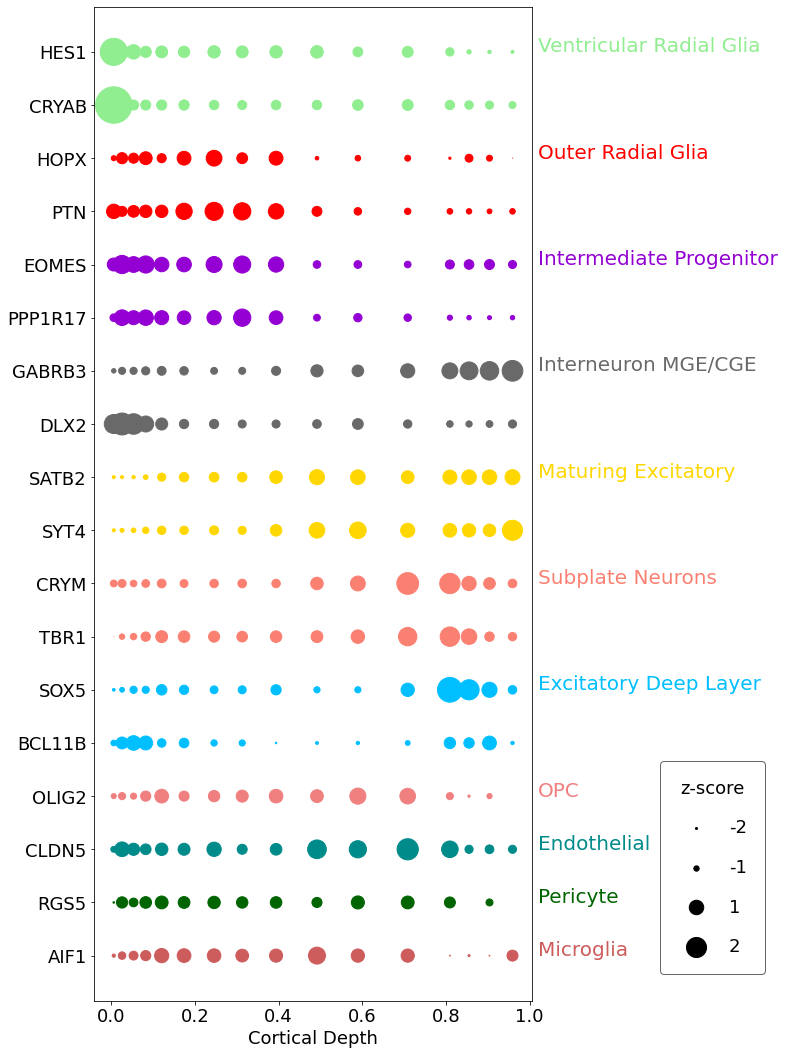

In [13]:
scaling = 3
power = 3

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

markers_genes = np.flipud(np.array(('HES1', 'CRYAB', 'HOPX',  'PTN',
                          'EOMES', 'PPP1R17', 'GABRB3', 'DLX2','SATB2', 'SYT4','CRYM','TBR1',
                           'SOX5', 'BCL11B',
                           'OLIG2',
                          'CLDN5', 'RGS5','AIF1')))

celltypes = np.flipud(np.array(('Ventricular Radial Glia', 'Ventricular Radial Glia',
                                'Outer Radial Glia', 'Outer Radial Glia',
                      'Intermediate Progenitor', 'Intermediate Progenitor',
                      'Interneuron MGE/CGE', 'Interneuron MGE/CGE','Maturing Excitatory', 'Maturing Excitatory', 
                      'Subplate Neurons','Subplate Neurons',
                      'Excitatory Deep Layer', 'Excitatory Deep Layer',
                      'OPC', 'Endothelial', 'Pericyte', 'Microglia')))

indexes = np.unique(celltypes, return_index=True)[1]
unique_celltypes = [celltypes[index] for index in sorted(indexes)]

genesForPlot = np.repeat(markers_genes,sum(subset_19pcw))
vcForPlot = np.array([adata.obs['VCDepth'].loc[subset_19pcw] for i in range(len(markers_genes))]).flatten()
countsForPlot = np.array([adata.layers['zscore_19pcw_corrected'][subset_19pcw, adata.var_names == markers_genes[i]] for i in range(len(markers_genes))])
coloursForPlot = np.concatenate([np.repeat(i, sum(celltypes == unique_celltypes[i]) * sum(subset_19pcw)) for i in range(len(unique_celltypes))])

plt.figure(figsize = (12,15))
plt.scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot) + countsForPlot)**power)*scaling,
            c = [cmap[x] for x in coloursForPlot])
plt.xlabel('Cortical Depth')
for i in range(len(unique_celltypes)):
    index = np.where([celltypes[j] == unique_celltypes[i] for j in range(len(celltypes))])[0]
    index = index[-1]
    plt.text(1.02, markers_genes[index], celltypes[index], fontsize=20, c = cmap[i])
plt.subplots_adjust(left=0.25)

#make a legend:
pws = [1,-2, -1, 1,2]
for pw in pws:
    plt.scatter([], [], s=((-np.amin(countsForPlot) + pw)**power)*scaling, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="z-score", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.25))
plt.tight_layout()
plt.savefig('../KR_NAS/0_publication_figures/Figure2A_MarkerGenes_CC-V2.pdf', bbox_extra_artists=(lgd,))

In [18]:
adata.obs['roi_dimension']

1       38360.6850
2      116076.5872
3      190168.1300
4      183145.4698
5      153183.3723
          ...     
273    170269.2774
274    269889.6721
275    105824.3811
276    112450.9649
278    219383.3811
Name: roi_dimension, Length: 255, dtype: float64

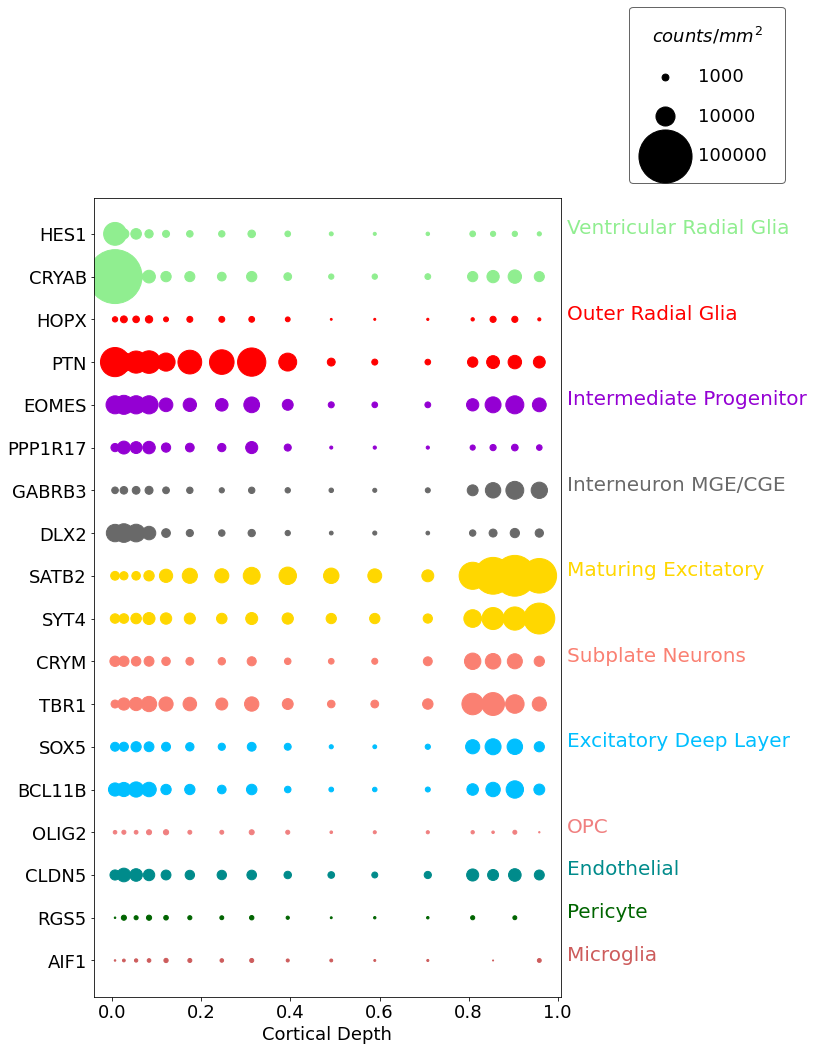

In [20]:
scaling = 0.1
power = 0.89

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

markers_genes = np.flipud(np.array(('HES1', 'CRYAB', 'HOPX',  'PTN',
                          'EOMES', 'PPP1R17', 'GABRB3', 'DLX2','SATB2', 'SYT4','CRYM','TBR1',
                           'SOX5', 'BCL11B',
                           'OLIG2',
                          'CLDN5', 'RGS5','AIF1')))

celltypes = np.flipud(np.array(('Ventricular Radial Glia', 'Ventricular Radial Glia',
                                'Outer Radial Glia', 'Outer Radial Glia',
                      'Intermediate Progenitor', 'Intermediate Progenitor',
                      'Interneuron MGE/CGE', 'Interneuron MGE/CGE','Maturing Excitatory', 'Maturing Excitatory', 
                      'Subplate Neurons','Subplate Neurons',
                      'Excitatory Deep Layer', 'Excitatory Deep Layer',
                      'OPC', 'Endothelial', 'Pericyte', 'Microglia')))

indexes = np.unique(celltypes, return_index=True)[1]
unique_celltypes = [celltypes[index] for index in sorted(indexes)]

genesForPlot = np.repeat(markers_genes,sum(subset_19pcw))
vcForPlot = np.array([adata.obs['VCDepth'].loc[subset_19pcw] for i in range(len(markers_genes))]).flatten()
normCounts = np.array([adata.layers['X_Corrected_V2'][i,:]/adata.obs['roi_dimension'].iloc[i] 
                                for i in range(np.shape(adata.X)[0])]) * 10**6
countsForPlot = np.array([normCounts[subset_19pcw, adata.var_names == markers_genes[i]] for i in range(len(markers_genes))])
coloursForPlot = np.concatenate([np.repeat(i, sum(celltypes == unique_celltypes[i]) * sum(subset_19pcw)) for i in range(len(unique_celltypes))])

plt.figure(figsize = (12,15))
plt.scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot) + countsForPlot)**power)*scaling,
            c = [cmap[x] for x in coloursForPlot])
plt.xlabel('Cortical Depth')
for i in range(len(unique_celltypes)):
    index = np.where([celltypes[j] == unique_celltypes[i] for j in range(len(celltypes))])[0]
    index = index[-1]
    plt.text(1.02, markers_genes[index], celltypes[index], fontsize=20, c = cmap[i])
plt.subplots_adjust(left=0.25)

#make a legend:
pws = [1,1000, 10000,100000]
for pw in pws:
    plt.scatter([], [], s=((-np.amin(countsForPlot) + pw)**power)*scaling, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="$counts/mm^2$", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.5, 1.25))
plt.tight_layout()
plt.savefig('../KR_NAS/0_publication_figures/SuppFig_MarkerGenes_DotPlotCountsMM-CCV2.pdf', bbox_extra_artists=(lgd,))

Make this plot as a count per mm line plot as well:

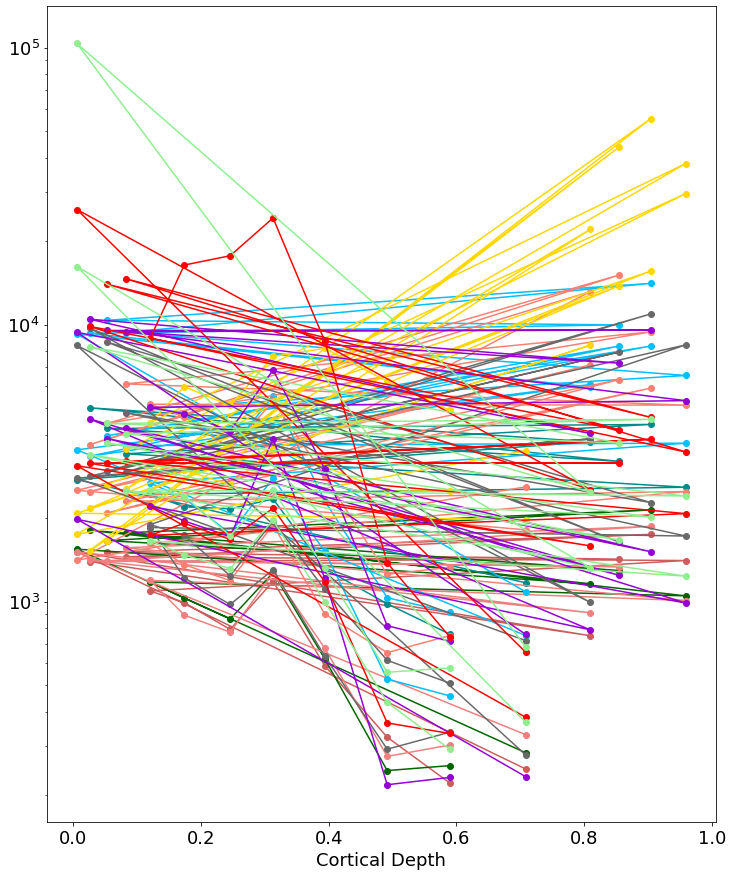

In [21]:

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

markers_genes = np.flipud(np.array(('HES1', 'CRYAB', 'HOPX',  'PTN',
                          'EOMES', 'PPP1R17', 'GABRB3', 'DLX2','SATB2', 'SYT4','CRYM','TBR1',
                           'SOX5', 'BCL11B', 'OLIG2',
                          'CLDN5', 'RGS5','AIF1')))

celltypes = np.flipud(np.array(('Ventricular Radial Glia', 'Ventricular Radial Glia',
                                'Outer Radial Glia', 'Outer Radial Glia',
                      'Intermediate Progenitor', 'Intermediate Progenitor',
                      'Interneuron MGE/CGE', 'Interneuron MGE/CGE','Maturing Excitatory', 'Maturing Excitatory', 
                      'Subplate Neurons','Subplate Neurons',
                      'Excitatory Deep Layer', 'Excitatory Deep Layer',
                      'OPC', 'Endothelial', 'Pericyte', 'Microglia')))

indexes = np.unique(celltypes, return_index=True)[1]
unique_celltypes = [celltypes[index] for index in sorted(indexes)]

vcForPlot = adata.obs['VCDepth'].loc[subset_19pcw]
coloursForPlot = np.concatenate([np.repeat(i, sum(celltypes == unique_celltypes[i]) * sum(subset_19pcw)) for i in range(len(unique_celltypes))])
normCounts = np.array([adata.layers['X_Corrected'][i,:]/adata.obs['roi_dimension'].iloc[:,0].iloc[i] 
                                for i in range(np.shape(adata.layers['X'])[0])]) * 10**6
countsForPlot = np.array([normCounts[subset_19pcw, adata.var_names == markers_genes[i]] for i in range(len(markers_genes))])
coloursForPlot = np.concatenate([np.repeat(i, sum(celltypes == unique_celltypes[i])) for i in range(len(unique_celltypes))])

plt.figure(figsize = (12,15))
for i in range(len(markers_genes)):
    plt.plot(vcForPlot, countsForPlot[i,:], '-ok', c = cmap[coloursForPlot[i]])
plt.yscale('log')
plt.xlabel('Cortical Depth')


plt.savefig('../KR_NAS/0_publication_figures/Figure2_MarkerGenes_LinePlot_CountsMM.pdf', bbox_extra_artists=(lgd,))

Same figure, slightly different format:

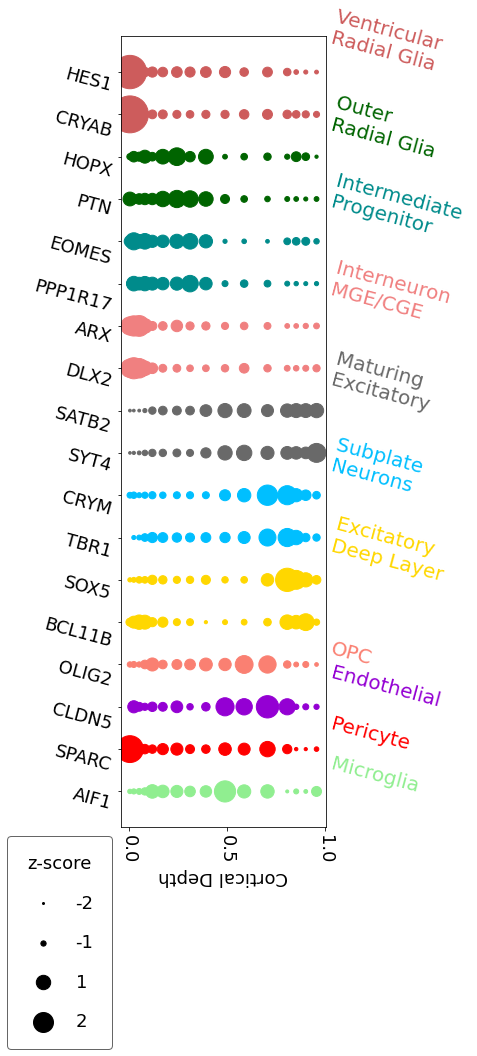

In [9]:
scaling = 3
power = 3

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

markers_genes = np.flipud(np.array(('HES1', 'CRYAB', 'HOPX',  'PTN',
                          'EOMES', 'PPP1R17', 'ARX', 'DLX2','SATB2', 'SYT4','CRYM','TBR1',
                           'SOX5', 'BCL11B',
                           'OLIG2',
                          'CLDN5', 'SPARC','AIF1')))


celltypes = np.flipud(np.array(('Ventricular \nRadial Glia', 'Ventricular \nRadial Glia',
                                'Outer \nRadial Glia', 'Outer \nRadial Glia',
                      'Intermediate \nProgenitor', 'Intermediate \nProgenitor',
                      'Interneuron \nMGE/CGE', 'Interneuron \nMGE/CGE','Maturing \nExcitatory', 'Maturing \nExcitatory', 
                      'Subplate \nNeurons','Subplate \nNeurons',
                      'Excitatory \nDeep Layer', 'Excitatory \nDeep Layer',
                      'OPC', 'Endothelial', 'Pericyte', 'Microglia')))

indexes = np.unique(celltypes, return_index=True)[1]
unique_celltypes = [celltypes[index] for index in sorted(indexes)]

genesForPlot = np.repeat(markers_genes,sum(subset_19pcw))
vcForPlot = np.array([adata.obs['VCDepth'].loc[subset_19pcw] for i in range(len(markers_genes))]).flatten()
countsForPlot = np.array([adata.layers['zscore_19pcw_corrected'][subset_19pcw, adata.var_names == markers_genes[i]] for i in range(len(markers_genes))])
coloursForPlot = np.concatenate([np.repeat(i, sum(celltypes == unique_celltypes[i]) * sum(subset_19pcw)) for i in range(len(unique_celltypes))])

plt.figure(figsize = (7,15))
plt.scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot) + countsForPlot)**power)*scaling,
            c = [cmap[x] for x in coloursForPlot])
plt.xlabel('Cortical Depth', rotation = -180)
for i in range(len(unique_celltypes)):
    index = np.where([celltypes[j] == unique_celltypes[i] for j in range(len(celltypes))])[0]
    index = index[-1]
    plt.text(1.02, markers_genes[index], celltypes[index], fontsize=20, c = cmap[i], rotation = -15)
plt.subplots_adjust(left=0.25)
plt.yticks(rotation=-15)
plt.xticks(rotation=-90)

#make a legend:
pws = [1,-2, -1, 1,2]
for pw in pws:
    plt.scatter([], [], s=((-np.amin(countsForPlot) + pw)**power)*scaling, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="z-score", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(0, 0))
plt.tight_layout()
plt.savefig('../KR_NAS/0_publication_figures/Figure2_MarkerGenes_Draft2.pdf', bbox_extra_artists=(lgd,))

Make a plot for interneuron markers:

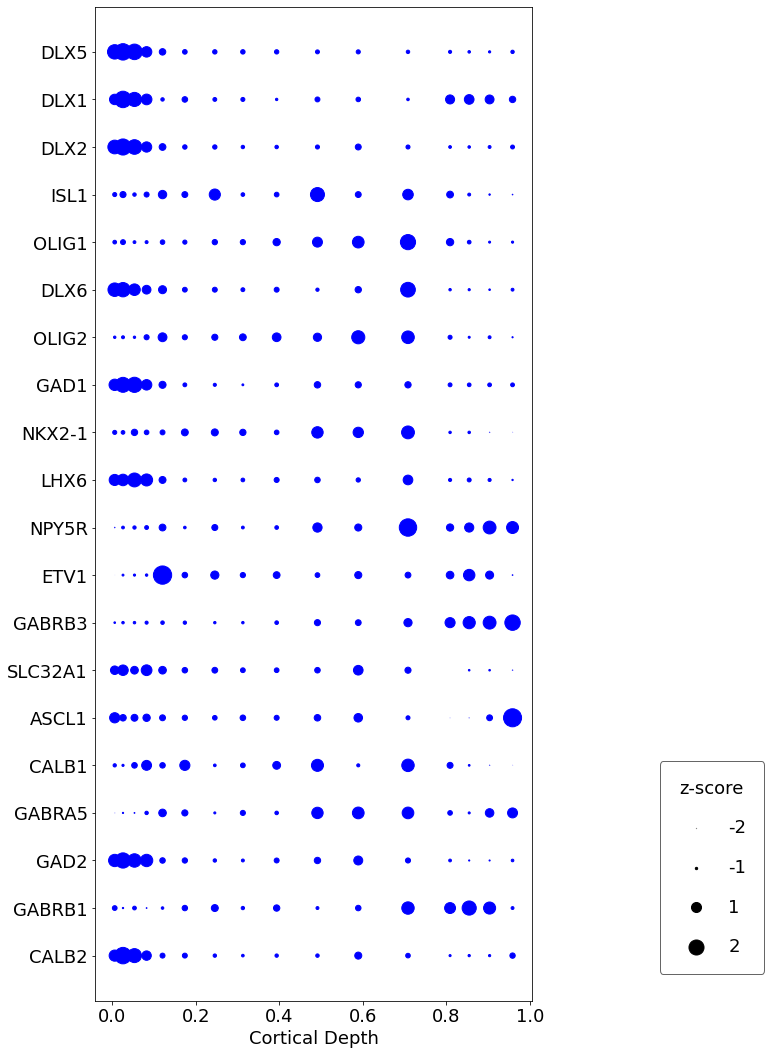

In [10]:
scaling = 3
power = 3

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

markers_genes = np.flipud(np.array((
'DLX5',
'DLX1', 
'DLX2' ,
'ISL1' ,
'OLIG1',
'DLX6' ,
'OLIG2' ,
'GAD1' ,
'NKX2-1', 
'LHX6' ,
'NPY5R',
'ETV1',
'GABRB3',
'SLC32A1',
'ASCL1',
'CALB1',
'GABRA5',
'GAD2',
'GABRB1',
'CALB2')))

genesForPlot = np.repeat(markers_genes,sum(subset_19pcw))
vcForPlot = np.array([adata.obs['VCDepth'].loc[subset_19pcw] for i in range(len(markers_genes))]).flatten()
countsForPlot = np.array([adata.layers['zscore_19pcw_corrected'][subset_19pcw, adata.var_names == markers_genes[i]] for i in range(len(markers_genes))])

plt.figure(figsize = (12,15))
plt.scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot) + countsForPlot)**power)*scaling,
            c = 'blue')
plt.xlabel('Cortical Depth')

plt.subplots_adjust(left=0.25)

#make a legend:
pws = [1,-2, -1, 1,2]
for pw in pws:
    plt.scatter([], [], s=((-np.amin(countsForPlot) + pw)**power)*scaling, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="z-score", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.25))
plt.tight_layout()
plt.savefig('../KR_NAS/0_publication_figures/Figure2_MarkerGenes_Interneurons_zScore.pdf', bbox_extra_artists=(lgd,))

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars


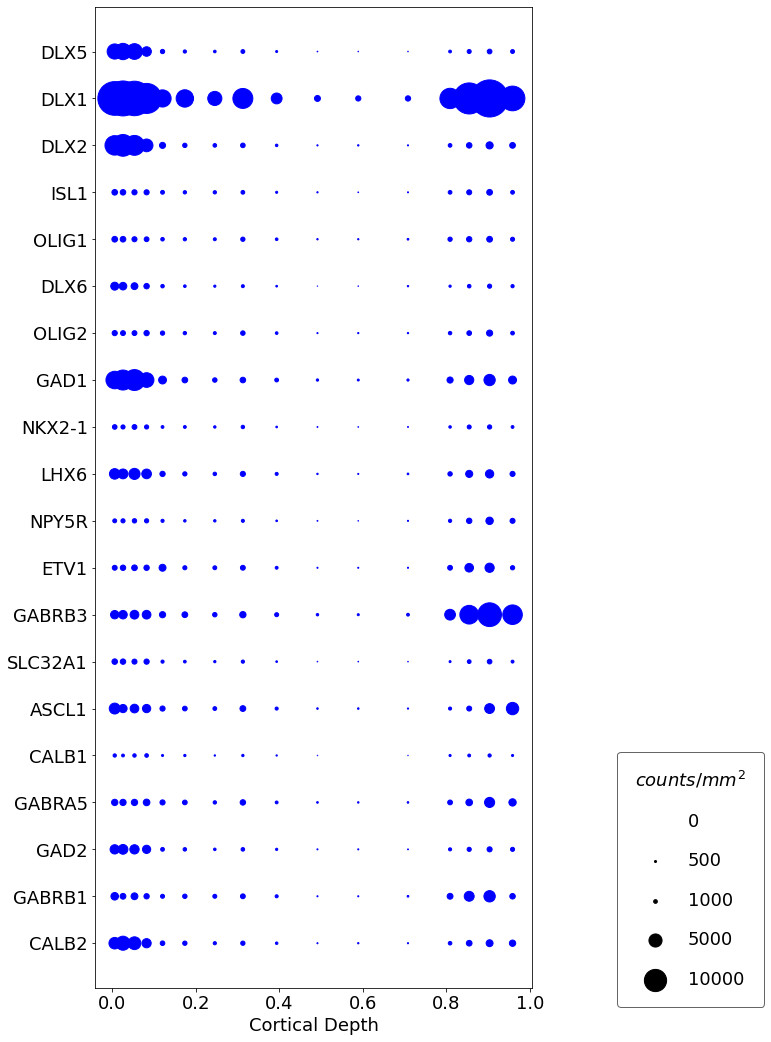

In [11]:
scaling = 0.0005
power = 1.5

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

markers_genes = np.flipud(np.array((
'DLX5',
'DLX1', 
'DLX2' ,
'ISL1' ,
'OLIG1',
'DLX6' ,
'OLIG2' ,
'GAD1' ,
'NKX2-1', 
'LHX6' ,
'NPY5R',
'ETV1',
'GABRB3',
'SLC32A1',
'ASCL1',
'CALB1',
'GABRA5',
'GAD2',
'GABRB1',
'CALB2')))

genesForPlot = np.repeat(markers_genes,sum(subset_19pcw))
vcForPlot = np.array([adata.obs['VCDepth'].loc[subset_19pcw] for i in range(len(markers_genes))]).flatten()
normCounts = np.array([adata.layers['X_Corrected'][i,:]/adata.obs['roi_dimension'].iloc[:,0].iloc[i] 
                                for i in range(np.shape(adata.layers['X'])[0])]) * 10**6
countsForPlot = np.array([normCounts[subset_19pcw, adata.var_names == markers_genes[i]] for i in range(len(markers_genes))])

plt.figure(figsize = (12,15))
plt.scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot) + countsForPlot)**power)*scaling,
            c = 'blue')
plt.xlabel('Cortical Depth')

plt.subplots_adjust(left=0.25)

#make a legend:
pws = [1,0, 500, 1000, 5000, 10000]
for pw in pws:
    plt.scatter([], [], s=((-np.amin(countsForPlot) + pw)**power)*scaling, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="$counts/mm^2$", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.25))
plt.tight_layout()
plt.savefig('../KR_NAS/0_publication_figures/Figure2_MarkerGenes_Interneurons_areaNormalized.pdf', bbox_extra_artists=(lgd,))

In [12]:
subset_14pcw = [adata.obs['AOI_type'][i] == 'Geometric' and 
                adata.obs['slide'][i] == '00MW' and
                adata.obs['Radial_position'][i] == 2 for i in range(np.shape(adata.obs)[0])]

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars


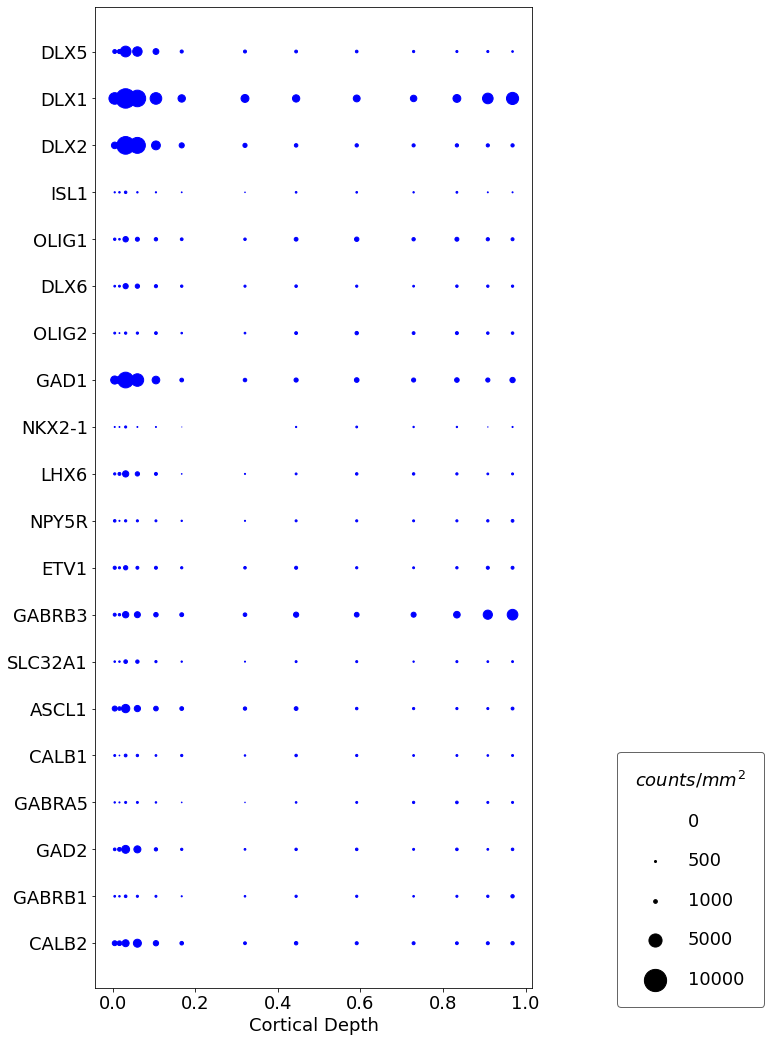

In [13]:
scaling = 0.0005
power = 1.5

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

markers_genes = np.flipud(np.array((
'DLX5',
'DLX1', 
'DLX2' ,
'ISL1' ,
'OLIG1',
'DLX6' ,
'OLIG2' ,
'GAD1' ,
'NKX2-1', 
'LHX6' ,
'NPY5R',
'ETV1',
'GABRB3',
'SLC32A1',
'ASCL1',
'CALB1',
'GABRA5',
'GAD2',
'GABRB1',
'CALB2')))

genesForPlot = np.repeat(markers_genes,sum(subset_14pcw))
vcForPlot = np.array([adata.obs['VCDepth'].loc[subset_14pcw] for i in range(len(markers_genes))]).flatten()
normCounts = np.array([adata.layers['X_Corrected'][i,:]/adata.obs['roi_dimension'].iloc[:,0].iloc[i] 
                                for i in range(np.shape(adata.layers['X'])[0])]) * 10**6
countsForPlot = np.array([normCounts[subset_14pcw, adata.var_names == markers_genes[i]] for i in range(len(markers_genes))])

plt.figure(figsize = (12,15))
plt.scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot) + countsForPlot)**power)*scaling,
            c = 'blue')
plt.xlabel('Cortical Depth')

plt.subplots_adjust(left=0.25)

#make a legend:
pws = [1,0, 500, 1000, 5000, 10000]
for pw in pws:
    plt.scatter([], [], s=((-np.amin(countsForPlot) + pw)**power)*scaling, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="$counts/mm^2$", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.25))
plt.tight_layout()
plt.savefig('../KR_NAS/0_publication_figures/Figure2_MarkerGenes_Interneurons_areaNormalized_14pcw.pdf', bbox_extra_artists=(lgd,))